In [1]:
# 1. Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
# 2. Import dataset
df = pd.read_csv("marketing_campaign.csv")

In [3]:
# 3. Visualisasi data frame (lihat 5 baris pertama)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
# 4. Hapus kolom yang tidak diperlukan (ID, tanggal, response/respon, dan lain-lain)
drop_cols = [
    "ID", "Dt_Customer",
    # Kolom response/respon kampanye
    "Response", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Complain"
]
df = df.drop(columns=drop_cols, errors="ignore")

In [5]:
# 5. Hapus data kosong dan duplikat
df = df.dropna()
df = df.drop_duplicates()

In [6]:
# 6. Statistik deskriptif: Income & Total Spending
spending_features = [col for col in df.columns if col.startswith("Mnt")]
df["Total_Spending"] = df[spending_features].sum(axis=1)

print("Income stats:\n", df["Income"].describe())
print("Total Spending stats:\n", df["Total_Spending"].describe())
df[["Income", "Total_Spending"]].describe()

Income stats:
 count      2015.000000
mean      52362.016377
std       25580.674925
min        1730.000000
25%       35533.500000
50%       51537.000000
75%       68641.000000
max      666666.000000
Name: Income, dtype: float64
Total Spending stats:
 count    2015.000000
mean      607.276427
std       602.806140
min         5.000000
25%        69.000000
50%       396.000000
75%      1047.500000
max      2525.000000
Name: Total_Spending, dtype: float64


,Income,Total_Spending
count,2015.000000,2015.000000
mean,52362.016377,607.276427
std,25580.674925,602.806140
min,1730.000000,5.000000
25%,35533.500000,69.000000
50%,51537.000000,396.000000
75%,68641.000000,1047.500000
max,666666.000000,2525.000000


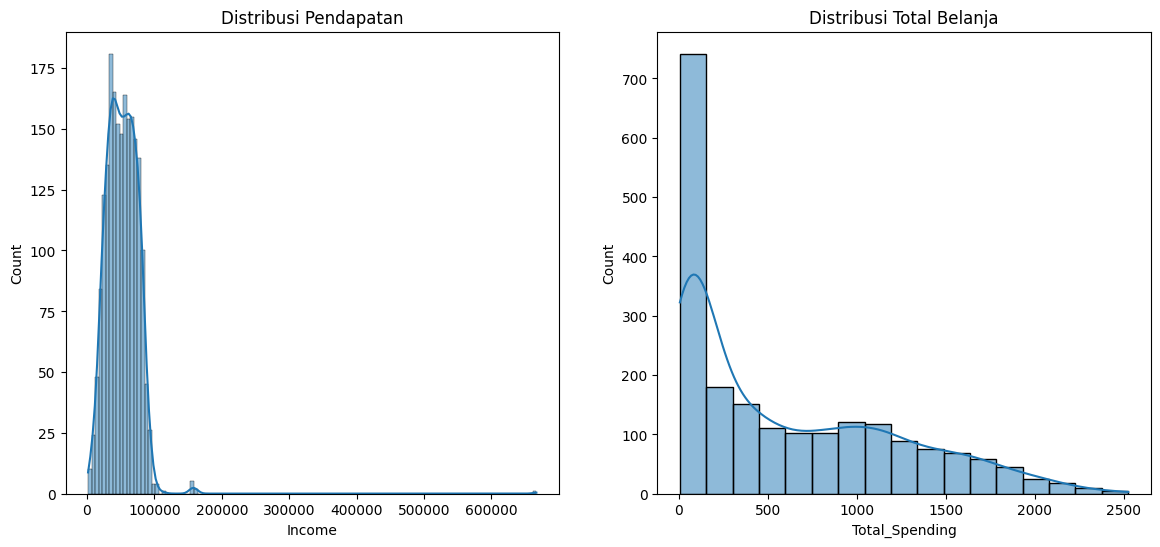

In [7]:
# 7. Visualisasi distribusi: Income & Total Spending
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.histplot(df["Income"], kde=True)
plt.title("Distribusi Pendapatan")

plt.subplot(1,2,2)
sns.histplot(df["Total_Spending"], kde=True)
plt.title("Distribusi Total Belanja")
plt.show()

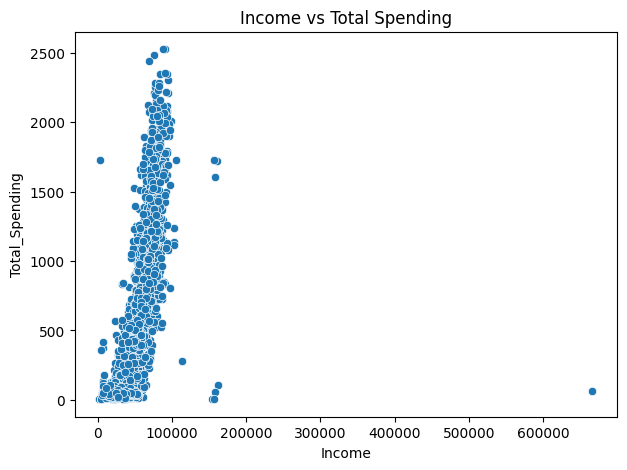

In [8]:
# 8. Visualisasi hubungan Income vs Total Spending
plt.figure(figsize=(7,5))
sns.scatterplot(x="Income", y="Total_Spending", data=df)
plt.title("Income vs Total Spending")
plt.show()

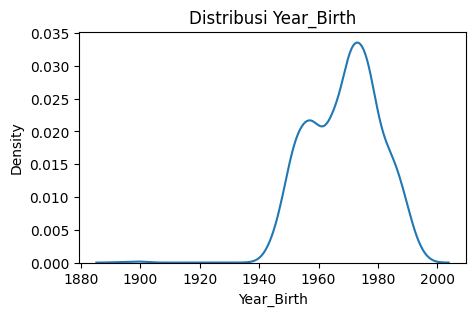

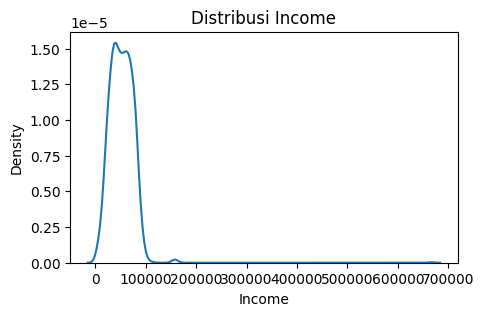

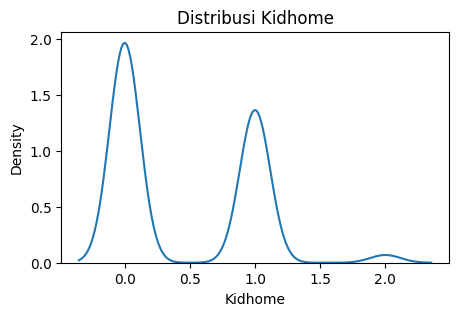

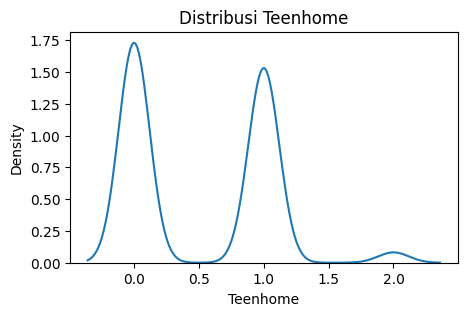

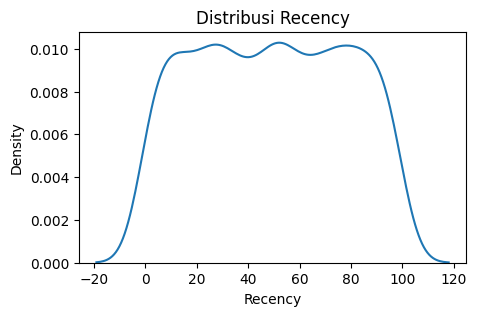

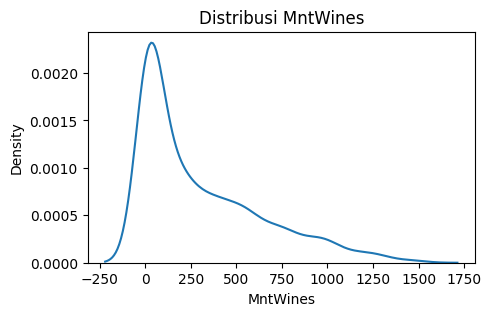

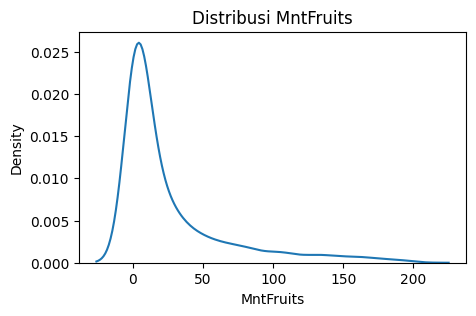

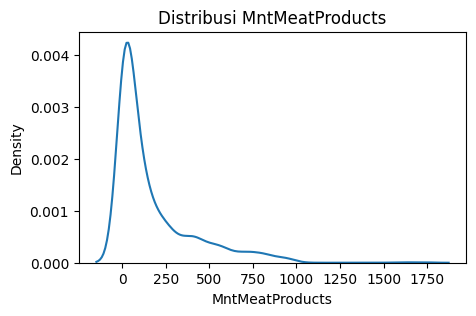

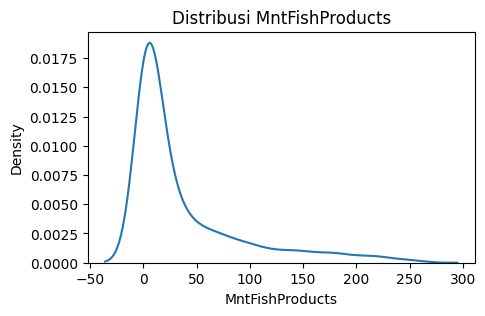

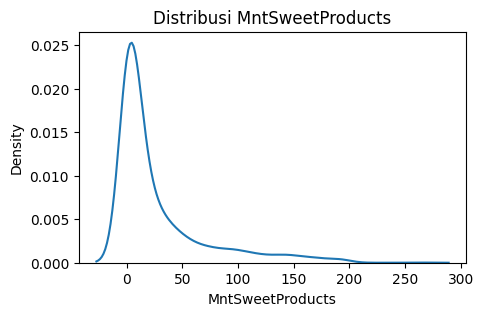

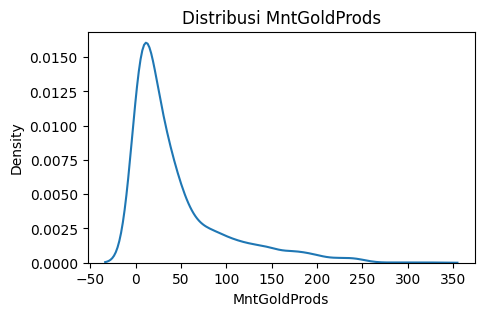

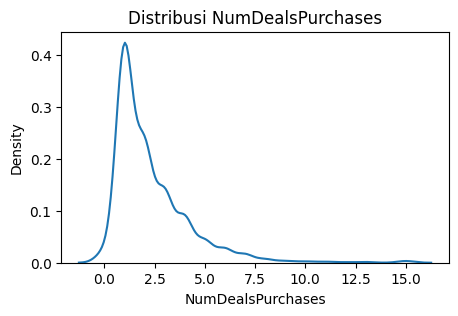

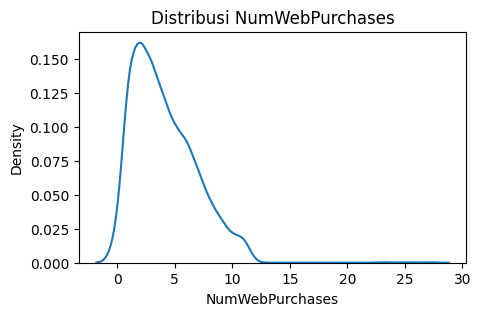

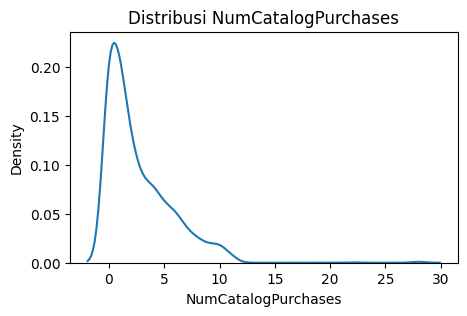

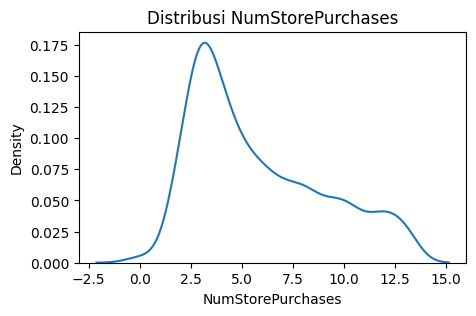

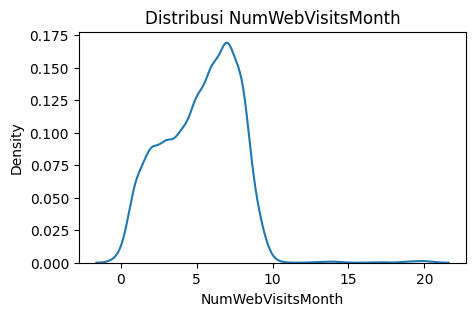

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12256\2307720258.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col)


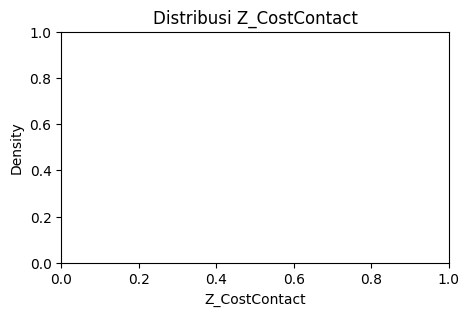

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12256\2307720258.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=col)


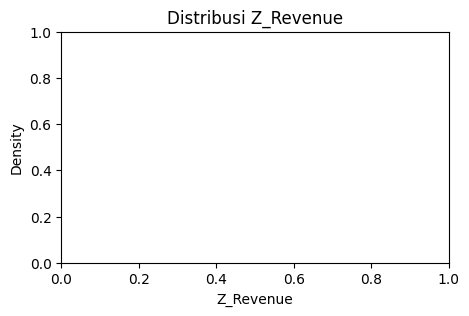

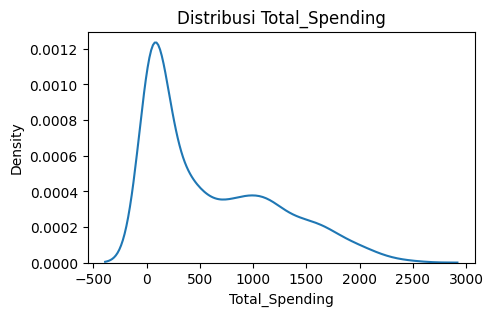

In [9]:
# 9. Periksa distribusi tiap fitur numerik dengan KDE
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(5,3))
    sns.kdeplot(data=df, x=col)
    plt.title('Distribusi %s' % col)
    plt.show()

In [10]:
# 10. Preprocessing: Encoding untuk kategorikal, Standardisasi numerik
label_cols = df.select_dtypes(include="object").columns
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

scaler = StandardScaler()
X = scaler.fit_transform(df[numeric_cols.drop("Total_Spending")])

In [ ]:
# 11. Scatter plot semua fitur numerik setelah scaling
sns.pairplot(pd.DataFrame(X, columns=numeric_cols.drop("Total_Spending")))
plt.show()

In [ ]:
# 12. Visualisasi hubungan antar fitur numerik (heatmap)
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Korelasi Antar Variabel Numerik")
plt.show()

In [ ]:
# 13. KMeans clustering + evaluasi
sse = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, sse, marker='o')
plt.xlabel('Jumlah Cluster (K)')
plt.ylabel('SSE')
plt.title('Elbow Method untuk KMeans')
plt.show()

In [ ]:
# 14. Ambil hasil KMeans (misal k=4, bisa disesuaikan dari elbow)
k_opt = 4
kmeans_final = KMeans(n_clusters=k_opt, random_state=42)
labels = kmeans_final.fit_predict(X)
df['cluster_kmeans'] = labels

sil_score = silhouette_score(X, labels)
db_index = davies_bouldin_score(X, labels)
print("KMeans - Silhouette Score:", sil_score)
print("KMeans - Davies-Bouldin Index:", db_index)

# Visualisasi hasil cluster
plt.figure(figsize=(7,5))
sns.scatterplot(x=df["Income"], y=df["Total_Spending"], hue=labels, palette="tab10")
plt.title("KMeans Clustering")
plt.show()

In [ ]:
# 15. DBSCAN clustering + evaluasi
dbscan = DBSCAN(eps=1.5, min_samples=10)
labels_db = dbscan.fit_predict(X)
df['cluster_dbscan'] = labels_db

# Evaluasi DBSCAN (exclude noise)
mask = labels_db != -1
if sum(mask) > 0 and len(np.unique(labels_db[mask])) > 1:
    sil_score_db = silhouette_score(X[mask], labels_db[mask])
    db_index_db = davies_bouldin_score(X[mask], labels_db[mask])
else:
    sil_score_db = None
    db_index_db = None
print("DBSCAN - Silhouette Score:", sil_score_db)
print("DBSCAN - Davies-Bouldin Index:", db_index_db)

# Visualisasi hasil DBSCAN
plt.figure(figsize=(7,5))
sns.scatterplot(x=df["Income"], y=df["Total_Spending"], hue=labels_db, palette="tab10")
plt.title("DBSCAN Clustering")
plt.show()